# Notebook for experimenting with different Recommender System Algorithm Performance in Surprise

In [1]:
#Importing Plotting and data modules
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
#Importing surprise modules
from surprise import Reader, accuracy, Dataset
from surprise.model_selection import KFold, cross_validate, train_test_split, GridSearchCV
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans
from surprise import KNNWithZScore, BaselineOnly, CoClustering

In [3]:
#reading in dataset
df = pd.read_csv("data.csv")

In [4]:
df.head()

,User,Game,Rating
0,dumedum,The Legend of Zelda: Breath of the Wild,10
1,dumedum,Tom Clancy's Ghost Recon: Shadow Wars 3D,10
2,dumedum,Darkman,10
3,Action51,Pokémon Sun and Moon,9
4,Action51,Twisted Fusion,7


For now, I'm going to filter out games all rows there the game wasn't rated. In the future, it may be worthwhile to figure out a way to impute these as implicit feedback for our system.

In [5]:
df = df[df["Rating"] != "No Score"]

In [6]:
print("Number of Unique Users in our dataset: ", df["User"].nunique())
print("Number of Unique Games in our dataset: ", df["Game"].nunique())

Number of Unique Users in our dataset:  392
Number of Unique Games in our dataset:  3572


In [7]:
#Distribution of Ratings by user
df["User"].value_counts(normalize=True)

Ghost-Piece         0.048615
ThanosReXXX         0.039692
SKTTR               0.033415
jump                0.019754
klingki             0.018892
bluemage1989        0.017169
JaxonH              0.016862
Spoony_Tech         0.015877
Quarth              0.013969
Magician            0.013477
DockEllisD          0.013108
Knighty_IX          0.012800
CaPPa               0.012431
Bezbot              0.011877
Sadist              0.011569
CaviarMeths         0.011569
CharlieGirl         0.010954
JoeDiddley          0.010892
RunninBlue          0.010523
antdickens          0.010462
Toadie              0.010338
NintendoByNature    0.009846
kkslider5552000     0.008615
Tyranexx            0.008615
MrGawain            0.008554
OorWullie           0.008369
Blue_Blur           0.008369
Matthew010          0.008246
VanillaLake         0.008000
KryptoniteKrunch    0.007938
                      ...   
Arbor               0.000062
ricklongo           0.000062
Qun_Mang            0.000062
cryptologous  

In [8]:
#Distribution of Rated Games
df["Game"].value_counts()

The Legend of Zelda: Breath of the Wild               191
Super Mario Odyssey                                   123
Mario Kart 8 Deluxe                                   117
The Legend of Zelda: Link's Awakening                 101
Splatoon 2                                             97
Super Smash Bros. Ultimate                             81
Super Mario 3D World                                   79
Mario Kart 8                                           78
Donkey Kong Country: Tropical Freeze                   75
Super Mario Maker                                      75
Super Mario Galaxy 2                                   70
Splatoon                                               70
Super Smash Bros. for Wii U                            68
The Legend of Zelda: A Link Between Worlds             68
The Legend of Zelda: Twilight Princess                 68
The Legend of Zelda: Ocarina of Time 3D                66
Mario + Rabbids Kingdom Battle                         65
Mario Kart 7  

(array([3.092e+03, 2.280e+02, 9.200e+01, 5.600e+01, 3.000e+01, 2.000e+01,
        2.100e+01, 6.000e+00, 7.000e+00, 3.000e+00, 7.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  1.        ,   7.33333333,  13.66666667,  20.        ,
         26.33333333,  32.66666667,  39.        ,  45.33333333,
         51.66666667,  58.        ,  64.33333333,  70.66666667,
         77.        ,  83.33333333,  89.66666667,  96.        ,
        102.33333333, 108.66666667, 115.        , 121.33333333,
        127.66666667, 134.        , 140.33333333, 146.66666667,
        153.        , 159.33333333, 165.66666667, 172.        ,
        178.33333333, 184.66666667, 191.        ]),
 <a list of 30 Patch objects>)

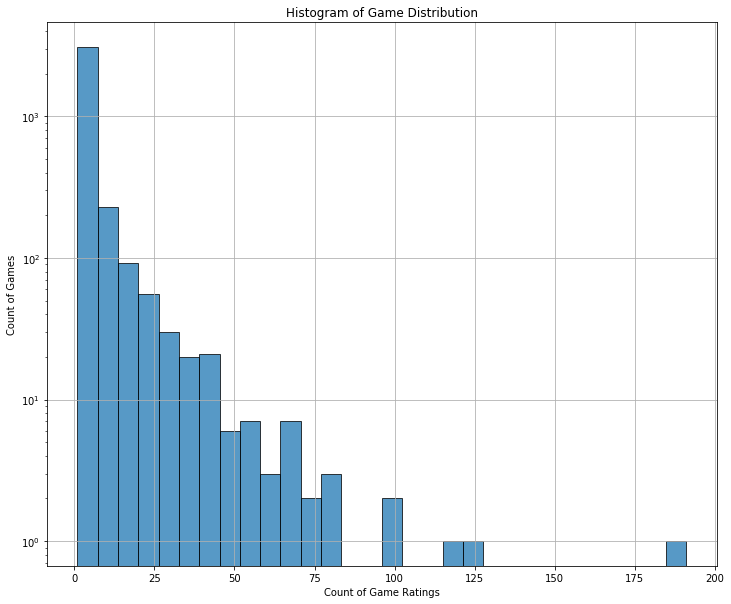

In [9]:
#Histogram of game distribution
plt.figure(figsize=(12,10))
plt.xlabel('Count of Game Ratings')
plt.ylabel('Count of Games')
plt.title('Histogram of Game Distribution')
plt.grid(True)
plt.hist(df.groupby("Game")["Rating"].count(), bins=30, log=True, alpha=0.75, edgecolor='black')

From the plot above, we can see that there were a few games that were rated over 100 times, but the vast majority of games were only rated once or twice.

(array([206.,  51.,  38.,  25.,  14.,  10.,  10.,   7.,   9.,   0.,   4.,
          4.,   2.,   3.,   1.,   0.,   1.,   2.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1.  ,  16.78,  32.56,  48.34,  64.12,  79.9 ,  95.68, 111.46,
        127.24, 143.02, 158.8 , 174.58, 190.36, 206.14, 221.92, 237.7 ,
        253.48, 269.26, 285.04, 300.82, 316.6 , 332.38, 348.16, 363.94,
        379.72, 395.5 , 411.28, 427.06, 442.84, 458.62, 474.4 , 490.18,
        505.96, 521.74, 537.52, 553.3 , 569.08, 584.86, 600.64, 616.42,
        632.2 , 647.98, 663.76, 679.54, 695.32, 711.1 , 726.88, 742.66,
        758.44, 774.22, 790.  ]),
 <a list of 50 Patch objects>)

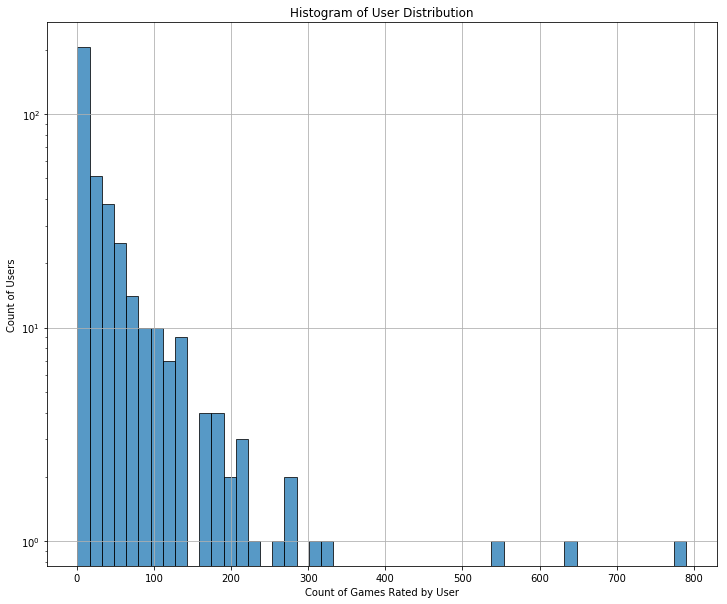

In [10]:
#Histogram of User Distribution
plt.figure(figsize=(12,10))
plt.xlabel('Count of Games Rated by User')
plt.ylabel('Count of Users')
plt.title('Histogram of User Distribution')
plt.grid(True)
plt.hist(df.groupby("User")["Rating"].count(), log=True, alpha=0.75, bins=50, edgecolor='black')

Again, the vast majority of users have only rated a couple of games, but a few users have rated over 300 games.

In [11]:
df.head()

,User,Game,Rating
0,dumedum,The Legend of Zelda: Breath of the Wild,10
1,dumedum,Tom Clancy's Ghost Recon: Shadow Wars 3D,10
2,dumedum,Darkman,10
3,Action51,Pokémon Sun and Moon,9
4,Action51,Twisted Fusion,7


In [12]:
df["Rating"].value_counts()

8     4286
9     3961
7     2927
10    2683
6     1090
5      437
4      272
3      229
1      219
2      146
Name: Rating, dtype: int64

In [19]:
df["Rating"] = df["Rating"].astype(int)

In [21]:
df["Rating"].value_counts()

8     4286
9     3961
7     2927
10    2683
6     1090
5      437
4      272
3      229
1      219
2      146
Name: Rating, dtype: int64

(array([ 219.,  146.,  229.,  272.,  437., 1090., 2927., 4286., 3961.,
        2683.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

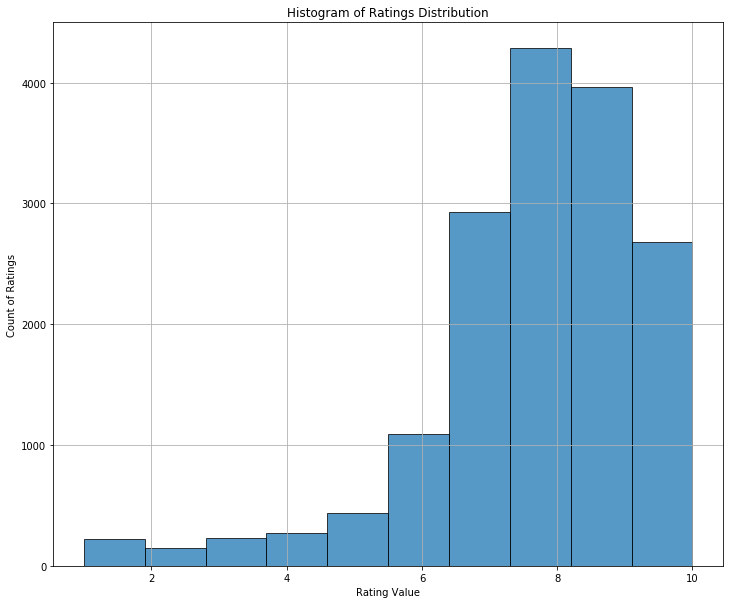

In [23]:
plt.figure(figsize=(12,10))
plt.xlabel('Rating Value')
plt.ylabel('Count of Ratings')
plt.title('Histogram of Ratings Distribution')
plt.grid(True)
plt.hist(df["Rating"], alpha=0.75, bins=10, edgecolor='black')

In [26]:
#Instantiating reader and dataset object
reader = Reader(rating_scale=(1, 10))
game_data = Dataset.load_from_df(df[['User', 'Game', 'Rating']], reader)

In [28]:
game_data.raw_ratings[0:5]

[('dumedum', 'The Legend of Zelda: Breath of the Wild', 10.0, None),
 ('dumedum', "Tom Clancy's Ghost Recon: Shadow Wars 3D", 10.0, None),
 ('dumedum', 'Darkman', 10.0, None),
 ('Action51', 'Pokémon Sun and Moon', 9.0, None),
 ('Action51', 'Twisted Fusion', 7.0, None)]

In [35]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, game_data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.405034,29.685702,0.386654
BaselineOnly,1.420964,0.033095,0.034838
SVD,1.421495,0.734824,0.066938
KNNBaseline,1.477070,0.041484,0.159917
KNNWithMeans,1.645116,0.025438,0.131078
KNNWithZScore,1.663831,0.042674,0.154395
SlopeOne,1.706358,0.361061,0.239164
CoClustering,1.708967,0.561069,0.034236
KNNBasic,1.749329,0.011696,0.155057


Looks like SVDpp, BaselineOnly and SVD are the most consistently good performers. Let's start with base SVDpp and learn some more about what it is predicting.

In [36]:
algo = SVDpp()
cross_validate(algo, game_data, measures=['RMSE'], cv=5, verbose=False)

{'test_rmse': array([1.43362821, 1.45203457, 1.4039261 , 1.43168406, 1.36708813]),
 'fit_time': (26.001811027526855,
  45.20916295051575,
  34.57229423522949,
  33.771703004837036,
  33.59991788864136),
 'test_time': (0.5263218879699707,
  0.46697998046875,
  0.43288087844848633,
  0.4689648151397705,
  0.4813811779022217)}

I realize that we should be using a validation set, but for now, I'm going to stick with the train/test split. 75/25 specifically.

In [37]:
trainset, testset = train_test_split(game_data, test_size=0.25)

In [38]:
algo = SVDpp()
predictions = algo.fit(trainset).test(testset)
print(accuracy.rmse(predictions))

RMSE: 1.3949
1.394899876643525


In [39]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0

In [40]:
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [42]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
1689,JaxonH,The Legend of Zelda: Breath of the Wild,10.0,10.0,{'was_impossible': False},203,136,0.0
3679,Hyrule,The Legend of Zelda: Breath of the Wild,10.0,10.0,{'was_impossible': False},6,136,0.0
2795,JaxonH,The Legend of Zelda: Ocarina of Time 3D,10.0,10.0,{'was_impossible': False},203,52,0.0
866,GeoChrome,Super Mario Odyssey,10.0,10.0,{'was_impossible': False},38,94,0.0
692,klingki,The Legend of Zelda: Breath of the Wild,10.0,10.0,{'was_impossible': False},228,136,0.0
1691,msm2000,The Legend of Zelda: Breath of the Wild,10.0,10.0,{'was_impossible': False},60,136,0.0
3616,Linkus,The Legend of Zelda: Breath of the Wild,10.0,10.0,{'was_impossible': False},25,136,0.0
488,Zuljaras,The Legend of Zelda: Majora's Mask 3D,10.0,10.0,{'was_impossible': False},27,32,0.0
1725,Spoony_Tech,The Legend of Zelda: Twilight Princess,10.0,10.0,{'was_impossible': False},197,49,0.0
273,Fandabidozi,Pokémon Yellow Version: Special Pikachu Edition,10.0,10.0,{'was_impossible': False},27,25,0.0


In [43]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
3389,Churchy,Pokémon Black and White 2,2.0,8.656594,{'was_impossible': False},96,18,6.656594
3028,BlueOcean,Crash Tag Team Racing,1.0,7.712503,{'was_impossible': False},43,3,6.712503
3779,GamingTelescope,Resident Evil 3: Nemesis,1.0,7.859513,{'was_impossible': False},59,7,6.859513
3345,Kyogre101,PANDA LOVE,1.0,7.916758,{'was_impossible': False},86,0,6.916758
3418,Ghost-Piece,Has-Been Heroes,10.0,2.785949,{'was_impossible': False},597,3,7.214051
3433,Gerald,Mario Kart: Double Dash!!,1.0,8.766212,{'was_impossible': False},21,35,7.766212
3102,citizenerased,FIFA 18,1.0,8.986695,{'was_impossible': False},14,5,7.986695
3610,Ralizah,Pokémon Diamond & Pearl,1.0,9.004177,{'was_impossible': False},77,19,8.004177
3274,F1R3F1Y,The Legend of Zelda: Breath of the Wild,1.0,9.071897,{'was_impossible': False},2,136,8.071897
569,AndreaF96,Final Fantasy XII: The Zodiac Age,1.0,9.078902,{'was_impossible': False},41,6,8.078902


In [46]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [47]:
top_n = get_top_n(predictions, n=10)

In [49]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Toadie ["Baldur's Gate: Dark Alliance", 'P.N.03', 'Pikmin', 'Lego Star Wars: The Video Game', 'Fire Emblem: Path of Radiance', 'Mario Golf: Toadstool Tour', 'Worms 3D', 'Mario Power Tennis', 'GUN', 'Future Tactics: The Uprising']
Gamer83 ['The Legend of Zelda: Breath of the Wild', 'The Legend of Zelda: A Link Between Worlds', 'Phoenix Wright: Ace Attorney Trilogy', 'Donkey Kong Country: Tropical Freeze', 'Super Mario Bros.', 'Super Mario Bros. 2', 'Phoenix Wright: Ace Attorney - Dual Destinies', 'Sonic Mania', 'New Super Mario Bros. U Deluxe', 'Mortal Kombat: Deadly Alliance']
SKTTR ['SoulCalibur II', 'Animal Crossing', 'The Legend of Zelda: The Wind Waker', 'Hollow Knight', 'Ghost Trick: Phantom Detective', 'Bayonetta', 'The Legend of Zelda: Twilight Princess HD', 'Donkey Kong Country Returns', 'Metroid Prime 2: Echoes', 'Elite Beat Agents']
RunninBlue ['The Legend of Zelda: The Wind Waker', 'The Legend of Zelda: A Link to the Past', 'The Legend of Zelda: Twilight Princess HD', 'The L